<a href="https://colab.research.google.com/github/Smiley8866/Colab/blob/main/Test_RF_Adversarial_Clamp_ART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/urwithajit9/ClaMP/refs/heads/master/dataset/ClaMP_Raw-5184.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1016k  100 1016k    0     0  1548k      0 --:--:-- --:--:-- --:--:-- 1550k


In [ ]:
!ls

ClaMP_Raw-5184.csv  sample_data


In [ ]:
import pandas as pd
db = pd.read_csv("ClaMP_Raw-5184.csv")
print(db.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_magic                      5184 non-null   int64  
 1   e_cblp                       5184 non-null   int64  
 2   e_cp                         5184 non-null   int64  
 3   e_crlc                       5184 non-null   int64  
 4   e_cparhdr                    5184 non-null   int64  
 5   e_minalloc                   5184 non-null   int64  
 6   e_maxalloc                   5184 non-null   int64  
 7   e_ss                         5184 non-null   int64  
 8   e_sp                         5184 non-null   int64  
 9   e_csum                       5184 non-null   int64  
 10  e_ip                         5184 non-null   int64  
 11  e_cs                         5184 non-null   int64  
 12  e_lfarlc                     5184 non-null   int64  
 13  e_ovno            

In [ ]:
legitimate = db[0:2501]
malware = db [2501:]

print(malware.take([1]))

print(legitimate.shape)
print(malware.shape)

      e_magic  e_cblp  e_cp  e_crlc  e_cparhdr  e_minalloc  e_maxalloc  e_ss  \
2502    23117     144     3       0          4           0       65535     0   

      e_sp  e_csum  ...  CheckSum  Subsystem  DllCharacteristics  \
2502   184       0  ...         0          2               32768   

      SizeOfStackReserve  SizeOfStackCommit  SizeOfHeapReserve  \
2502             1048576               4096            1048576   

      SizeOfHeapCommit  LoaderFlags  NumberOfRvaAndSizes  class  
2502              4096            0                   16      1  

[1 rows x 56 columns]
(2501, 56)
(2683, 56)


In [ ]:
data_in = db.drop(["class", "e_res", "e_res2"], axis=1).values
labels = db["class"].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
)

legitimate_train, legitimate_test, mal_train, mal_test = train_test_split(data_in, labels, test_size=0.35)
model = RandomForestClassifier(n_estimators=53)

# Training
model.fit(legitimate_train, mal_train)

# Test
predicted = model.predict(legitimate_test)

# Accuracy
accuracy = accuracy_score(predicted, mal_test)
print("Accuracy: ", accuracy)

Accuracy:  0.9845708775313404


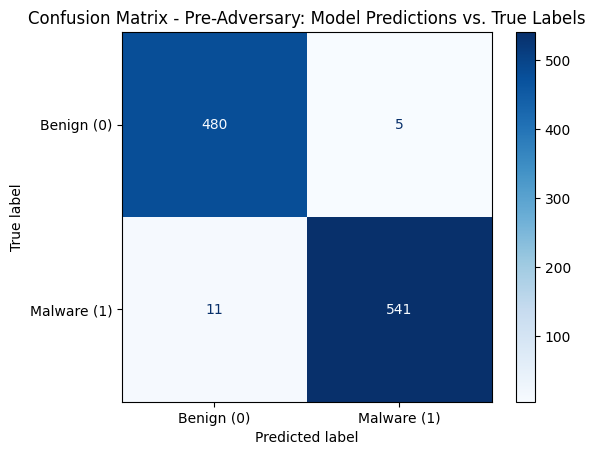

🧪 Evaluation Metrics:
Accuracy : 0.98
Precision: 0.99
Recall   : 0.98
F1 Score : 0.98


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt

# Labels for display
display_labels = ["Benign (0)", "Malware (1)"]

# Confusion matrix
cm = confusion_matrix(mal_test, predicted, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Pre-Adversary: Model Predictions vs. True Labels")
plt.show()

# Metrics
accuracy = accuracy_score(mal_test, predicted)
precision = precision_score(mal_test, predicted, zero_division=0)
recall = recall_score(mal_test, predicted, zero_division=0)
f1 = f1_score(mal_test, predicted, average="weighted", zero_division=0)

# Print results
print("🧪 Evaluation Metrics:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

In [ ]:
#install ART
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00


In [ ]:
#Wrap scikit-learn Model with ART toolbox
from art.estimators.classification import SklearnClassifier
art_classifier = SklearnClassifier(model=model)

In [ ]:
from art.attacks.evasion import HopSkipJump
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
import logging

# Suppress ART warnings, otherwise we'd get 1 line per test.
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("art.attacks.evasion.hop_skip_jump").setLevel(logging.ERROR)

# Scale test data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(legitimate_test[:1000])
X_adv_test = X_scaled
y_adv_test = mal_test[:1000]

# Run HopSkipJump
try:
    print("🔍 Running HopSkipJump...")
    hsj_attack = HopSkipJump(
        classifier=art_classifier,
        norm=2,
        max_iter=100,
        max_eval=10000,
        init_eval=10,
        verbose=True
    )
    X_adv_samples = hsj_attack.generate(x=X_adv_test)
    print("✅ Adversarial samples generated.")

    # Evaluate effectiveness of attack
    y_pred_clean = model.predict(X_adv_test)
    y_pred_adv = model.predict(X_adv_samples)

    # Compute success rate: proportion of samples that changed prediction
    success_rate = np.mean(y_pred_clean != y_pred_adv)
    print(f"🎯 HSJ Attack Success Rate: {success_rate * 100:.2f}%")

except Exception as e:
    print("❌ HSJ attack failed:", str(e))
    X_adv_samples = X_adv_test  # fallback

🔍 Running HopSkipJump...


HopSkipJump:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Adversarial samples generated.
🎯 HSJ Attack Success Rate: 0.00%


In [ ]:
#show results
unchanged = np.sum(np.all(X_adv_samples == X_adv_test, axis=1))
print(f"🧪 Number of adversarial samples unchanged: {unchanged}/{len(X_adv_test)}")

🧪 Number of adversarial samples unchanged: 0/1000


In [ ]:
from art.attacks.evasion import BoundaryAttack
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
import logging

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("art.attacks.evasion").setLevel(logging.ERROR)

# Preprocess test data (scaling is required for many classifiers)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(legitimate_test[:1000])
y_scaled = mal_test[:1000]

# Boundary Attack setup
try:
    print("🔍 Running Boundary Attack...")

    boundary_attack = BoundaryAttack(
        estimator=art_classifier,
        targeted=False,
        max_iter=1000,
        delta=0.01,
        epsilon=0.01,
        verbose=True
    )

    X_adv_samples = boundary_attack.generate(x=X_scaled)
    print("✅ Adversarial samples generated.")

    # Evaluate
    y_pred_clean = model.predict(X_scaled)
    y_pred_adv = model.predict(X_adv_samples)
    success_rate = np.mean(y_pred_clean != y_pred_adv)

    print(f"🎯 Boundary Attack Success Rate: {success_rate * 100:.2f}%")

except Exception as e:
    print("❌ Boundary Attack failed:", str(e))
    X_adv_samples = X_scaled

🔍 Running Boundary Attack...


Boundary attack:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Adversarial samples generated.
🎯 Boundary Attack Success Rate: 0.00%


In [ ]:
#show results
unchanged = np.sum(np.all(X_adv_samples == X_adv_test, axis=1))
print(f"🧪 Number of adversarial samples unchanged: {unchanged}/{len(X_adv_test)}")